Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at

  http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.  

### Hybrid Parallel Drone Classifier

In [ ]:
USING_COLAB = True
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    USING_COLAB = False

In [ ]:
import sys

if USING_COLAB is True:
    radar_path = "/content/drive/MyDrive/Radar"
else:
    radar_path = "Radar"
if radar_path not in sys.path:
    sys.path.insert(0, radar_path)
data_dir = "two_sided"
model_dir = "two_sided_models"
plot_dir = "two_sided_plots"
roc_curve_minimum = 1e-3

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as ds
from torcheval.metrics.functional import multiclass_f1_score

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

drone_type_map = ["DJI_Matrice_300_RTK", "DJI_Mavic_Air_2",
                  "DJI_Mavic_Mini", "DJI_Phantom_4", "Parrot_Disco"]

In [ ]:
!pip install wandb
!pip install mlxtend
!pip install pennylane

In [ ]:
import pennylane as qml

# Define the quantum circuit using PennyLane
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode0(inputs, weights):
    #print(f"qnode0: {weights=}")
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev)
def qnode1(inputs, weights):
    #print(f"qnode1: {weights=}")
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev)
def qnode2(inputs, weights):
    #print(f"qnode2: {weights=}")
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev)
def qnode3(inputs, weights):
    #print(f"qnode3: {weights=}")
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Define the QLayer
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits)}


class HybridRadarClassifier(nn.Module):
  def __init__(self, conf):
        super(HybridRadarClassifier, self).__init__()

        # i/p shape - (batch_size, Channel_in, Height_in, Width_in) - (2, 16, 251)
        self.conv1 = nn.Conv2d(2, 16, (3,3), padding =1) # o/p shape - (16, 16, 251)
        self.IN1 = nn.InstanceNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2, padding =1) # o/p shape (16, 8, 126)
        self.conv2 = nn.Conv2d(16, 32, (5,5), padding = 2) # o/p shape (32, 8, 126)
        self.IN2 = nn.InstanceNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2) # o/p shape (32, 4, 63)

        #quantum layer
        self.qlayer1 = qml.qnn.TorchLayer(qnode0, weight_shapes)
        self.qlayer2 = qml.qnn.TorchLayer(qnode1, weight_shapes)
        self.qlayer3 = qml.qnn.TorchLayer(qnode2, weight_shapes)
        self.qlayer4 = qml.qnn.TorchLayer(qnode3, weight_shapes)

        #fully connected layers
        self.fc1 = nn.Linear( 32 * 12 * 21 , 120)
        self.fc2 = nn.Linear( 120 , 20 )
        self.fc3 = nn.Linear( 20 , 5)  # o/p shape should be (batch_size,5,1,1)

        self.drop = nn.Dropout2d(p=0.5)
        self.relu = nn.LeakyReLU()

  def forward(self, x):
        # i/p shape - (batch_size, Channel_in, Height_in, Width_in) - (2, 16, 251)
        x = self.pool1(self.relu(self.IN1(self.conv1(x))))
        x = self.drop(x)
        x = self.pool2(self.relu(self.IN2(self.conv2(x))))
        x = self.drop(x)
        #flatten
        x = x.view(-1, 32 * 12 * 21) # x = torch.flatten(x, start_dim=1
        #FC layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        # qlayers connected parallely
        # Make sure the values are normalised to lie in the range [0,pi]
        # since the qnodes are using angle embedding
        x = F.normalize(x) * np.pi
        x_1, x_2, x_3, x_4 = torch.split(x, 5, dim=1)
        #print(f"input {x_1=}")
        x_1 = self.qlayer1(x_1)
        x_2 = self.qlayer2(x_2)
        x_3 = self.qlayer3(x_3)
        x_4 = self.qlayer4(x_4)
        #print(f"output {x_1=}")
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)

     # if we want qlayers connected serially?
       # x = self.qlayer1(x)
       # x = self.qlayer2(x)
       # x = self.qlayer3(x)
       # x = self.qlayer4(x)

        x = self.fc3(x)
        return x


In [ ]:
import time
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import torchvision
import torch.nn.functional as F
import torchvision.datasets as ds
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay


model_path = f"{radar_path}/{model_dir}"
plot_path = f"{radar_path}/{plot_dir}"
os.system(f"mkdir -p {model_path}")
os.system(f"mkdir -p {plot_path}")


def dataloader(file_extension):
    data = np.load(file_extension)
    return data


def plot_spectrogram(sp):
    fig, axs = plt.subplots(2, ncols=1, figsize=(14,3))

    axs[0].imshow(sp[0])
    axs[1].imshow(sp[1])

    plt.tight_layout()
    plt.show()


def plot_multiclass_roc(target, probs, snr, plot_file=None,
                        remove_zeros=False, semilog_axes=True):
    lb = LabelBinarizer().fit(target)
    one_hot_target = lb.transform(target)

    fig, ax = plt.subplots(figsize=(5, 5))
    colors = cycle(['#348ABD', '#b74331', '#8EBA42', '#FBC15E', '#988ED5'])
    for class_id, color in zip(range(5), colors):
        fpr, tpr, _ = roc_curve(one_hot_target[:,class_id], probs[:,class_id])
        if remove_zeros is True:
            zero_indices = np.where(np.isclose(fpr, 0))
            fpr = np.delete(fpr, zero_indices)
            tpr = np.delete(tpr, zero_indices)
        else:
            fpr[np.isclose(fpr,0)] = 1e-10
        display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(
            name=f"{drone_type_map[class_id]}",
            ax=ax,
            color=color)
    if semilog_axes is True:
        display.ax_.set_xscale("log")
        display.ax_.set_xlim(roc_curve_minimum, 1.0)
    display.ax_.set_xlabel("False Positive Rate")
    display.ax_.set_ylabel("True Positive Rate")
    line = plt.plot(np.geomspace(roc_curve_minimum,1.0), np.geomspace(roc_curve_minimum,1.0),
                    color='k', linestyle="dashed", label="Chance")
    display.ax_.set_title(f"ROC curves for SNR {snr}dB")
    display.ax_.legend()
    plt.tight_layout()
    if plot_file is not None:
        plt.savefig(plot_file)
    else:
        plt.show()


def train(conf, trainLoader, device):

    net = HybridRadarClassifier(conf).to(device)

    optim = torch.optim.AdamW(net.parameters(), lr=conf["learning_rate"])
    criterion = nn.CrossEntropyLoss().to(device)

    for x in range(conf["epochs"]):

        net.train()

        for i, data in enumerate(trainLoader):
            # plot_spectrogram(torch.squeeze(data[0]))
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optim.zero_grad()

            outputs = net(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()
            loss_val = loss.item()

        print('Train Epoch: {} Loss: {:.6f}'.format(x, loss_val))
        if x > conf['min_epochs'] and loss_val < conf['loss_threshold']:
            break

    if conf['save_model'] is True:
        print(f"Saving model state to {conf['model_path']}")
        torch.save(net.state_dict(), conf['model_path'])


def test(conf, testLoader, device, plot_dir=None):

    # load model state
    net = HybridRadarClassifier(conf).to(device)
    net.load_state_dict(torch.load(conf['model_path']))
    net.eval()

    correct = 0
    total = 0
    testloss = 0
    predicted = None
    probabilities = None
    target = None

    loss_fn = nn.CrossEntropyLoss().to(device)

    confm = np.zeros((5, 5), dtype=int)
    for i, data in enumerate(testLoader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if target is None:
            target = labels
        else:
            target = torch.cat((target, labels))

        outputs = net(inputs.float())
        loss = loss_fn(outputs, labels)
        testloss += loss.item()

        partial_probabilities = nn.Softmax(dim=1)(outputs.data)
        if probabilities is None:
            probabilities = partial_probabilities
        else:
            probabilities = torch.cat((probabilities, partial_probabilities))

        _, partial_predicted = torch.max(outputs.data, 1)
        if predicted is None:
            predicted = partial_predicted
        else:
            predicted = torch.cat((predicted, partial_predicted))

    roc_plot_file = None
    conf_plot_file = None
    if plot_dir is not None:
        roc_plot_file = f"{plot_dir}/hybrid_classifier_roc_model-{model_snr}_signal-{conf['SNR']}.pdf"
        conf_plot_file = f"{plot_dir}/hybrid_classifier_conf_model-{model_snr}_signal-{conf['SNR']}.pdf"
    plot_multiclass_roc(target, probabilities, conf['SNR'], plot_file=roc_plot_file)

    confm = confusion_matrix(target, predicted)
    print(f"{confm=}")
    if conf['plot_confusion'] is True:
        plt.close()
        fig, ax = plot_confusion_matrix(conf_mat=confm,
                                        show_normed=True,
                                        colorbar=True,
                                        class_names=drone_type_map)
        ax.set_title(f"Confusion matrix for SNR {conf['SNR']}dB")
        plt.tight_layout()
        if conf_plot_file is not None:
            plt.savefig(conf_plot_file)
        else:
            plt.show()

    f1 = multiclass_f1_score(predicted, target, num_classes=5, average='micro')
    print(f"{f1=}")


### Training Code

In [ ]:

#for snr, threshold in zip([20, 15, 10, 5, 0, -5],
#                          [0.01, 0.01, 0.01, 0.05, 0.1, 0.1]):
for snr, threshold in zip([5],
                          [0.002]):
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 8
    conf['epochs'] = 200
    conf['min_epochs'] = 50
    conf['learning_rate'] = 0.001
    conf['loss_threshold'] = threshold
    conf['save_model'] = True
    conf['model_path'] = f"{model_path}/hybrid-parallel-model-{snr}.pt"

    trainset_root = f"{radar_path}/{data_dir}/trainset/{conf['f_s']}fs/{conf['SNR']}SNR"
    trainds = ds.DatasetFolder(trainset_root, dataloader, extensions=("npy",))
    trainLoader = torch.utils.data.DataLoader(trainds, conf["batch_size"], shuffle=True, num_workers=2)

    print(f"SNR: {snr} dB")
    train(conf, trainLoader, device)

SNR: 5 dB
Train Epoch: 0 Loss: 1.603691
Train Epoch: 1 Loss: 1.494778
Train Epoch: 2 Loss: 1.441627
Train Epoch: 3 Loss: 0.687232
Train Epoch: 4 Loss: 0.291539
Train Epoch: 5 Loss: 0.409417
Train Epoch: 6 Loss: 0.115797
Train Epoch: 7 Loss: 0.258805
Train Epoch: 8 Loss: 0.249489
Train Epoch: 9 Loss: 0.225890
Train Epoch: 10 Loss: 0.012996
Train Epoch: 11 Loss: 0.010339
Train Epoch: 12 Loss: 0.041649
Train Epoch: 13 Loss: 0.006428
Train Epoch: 14 Loss: 0.005465
Train Epoch: 15 Loss: 0.004840
Train Epoch: 16 Loss: 0.004651
Train Epoch: 17 Loss: 0.213542
Train Epoch: 18 Loss: 0.004164
Train Epoch: 19 Loss: 0.162341
Train Epoch: 20 Loss: 0.012024
Train Epoch: 21 Loss: 0.182643
Train Epoch: 22 Loss: 0.005701
Train Epoch: 23 Loss: 0.014587
Train Epoch: 24 Loss: 0.065478
Train Epoch: 25 Loss: 0.003709
Train Epoch: 26 Loss: 0.004268
Train Epoch: 27 Loss: 0.069232
Train Epoch: 28 Loss: 0.205037
Train Epoch: 29 Loss: 0.019543
Train Epoch: 30 Loss: 0.003353
Train Epoch: 31 Loss: 0.085443
Train Ep

### Model Evaluation

SNR: 20 dB
confm=array([[985,   2,   7,   3,   3],
       [  0, 981,  15,   4,   0],
       [  3,   1, 986,  10,   0],
       [  1,   1,   7, 991,   0],
       [  0,   0,   6,   3, 991]])
f1=tensor(0.9868)
SNR: 15 dB
confm=array([[977,   4,   8,   5,   6],
       [  0, 976,  11,  11,   2],
       [  4,   4, 967,  21,   4],
       [  3,   1,  16, 978,   2],
       [  2,   2,   9,   4, 983]])
f1=tensor(0.9762)
SNR: 10 dB
confm=array([[969,   5,   8,   8,  10],
       [ 10, 960,  14,  12,   4],
       [  8,   2, 967,  17,   6],
       [ 12,   7,  15, 959,   7],
       [  7,   3,   9,  13, 968]])
f1=tensor(0.9646)
SNR: 5 dB
confm=array([[924,  21,  15,  15,  25],
       [ 33, 933,   6,  15,  13],
       [ 34,  14, 913,  26,  13],
       [ 34,   8,  17, 932,   9],
       [ 36,   8,  14,   9, 933]])
f1=tensor(0.9270)
SNR: 0 dB
confm=array([[890,  33,  16,  36,  25],
       [ 89, 846,  26,  26,  13],
       [102,  26, 808,  39,  25],
       [ 89,  27,  25, 847,  12],
       [ 98,  16,  26,  2

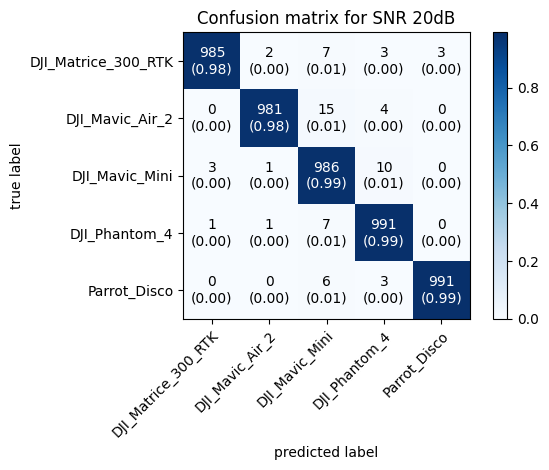

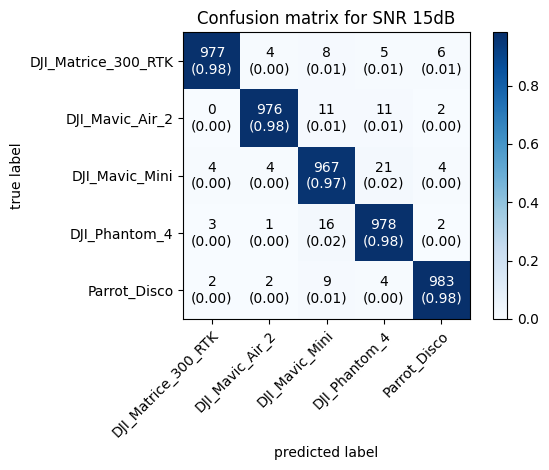

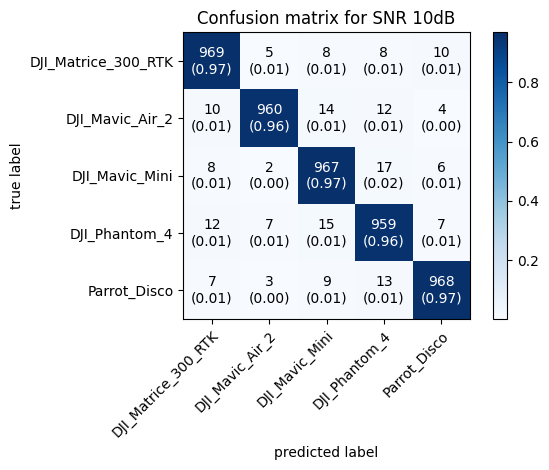

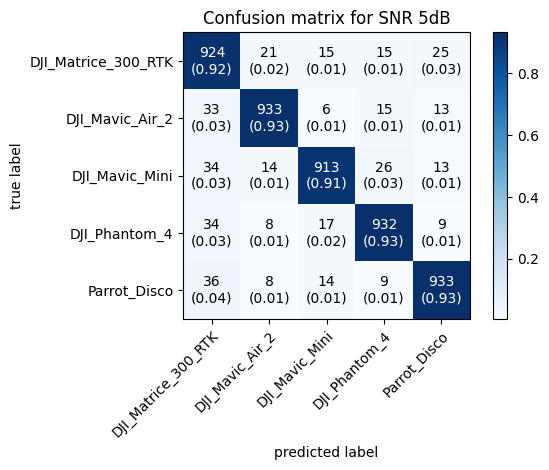

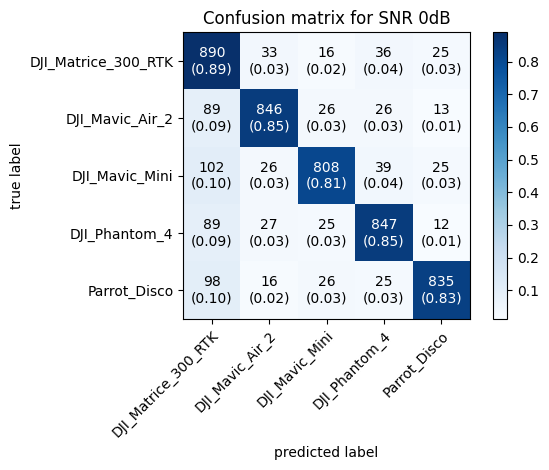

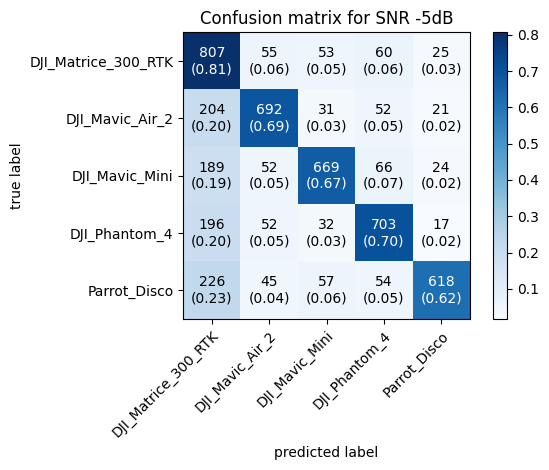

In [ ]:
model_snr = 5
for snr in [20, 15, 10, 5, 0, -5]:
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 8
    conf['epochs'] = 10
    conf['learning_rate'] = 0.001
    conf['plot_confusion'] = True
    conf['model_path'] = f"{model_path}/hybrid-parallel-model-{model_snr}.pt"

    testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
    testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
    testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

    print(f"SNR: {snr} dB")
    test(conf, testLoader, device, plot_dir=plot_path)

### Generate Plots from Model Evaluation Results

Model evaluation for SNR=20
Model evaluation for SNR=15
Model evaluation for SNR=10
Model evaluation for SNR=5
Model evaluation for SNR=0
Model evaluation for SNR=-5



F1 Scores for Model Trained with SNR=5

Signal SNR      F1 Score
------------------------
   20   :     0.987
   15   :     0.976
   10   :     0.965
   5    :     0.927
   0    :     0.845
   -5   :     0.698





/tmp/ipykernel_3989/3317197277.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3989/3317197277.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


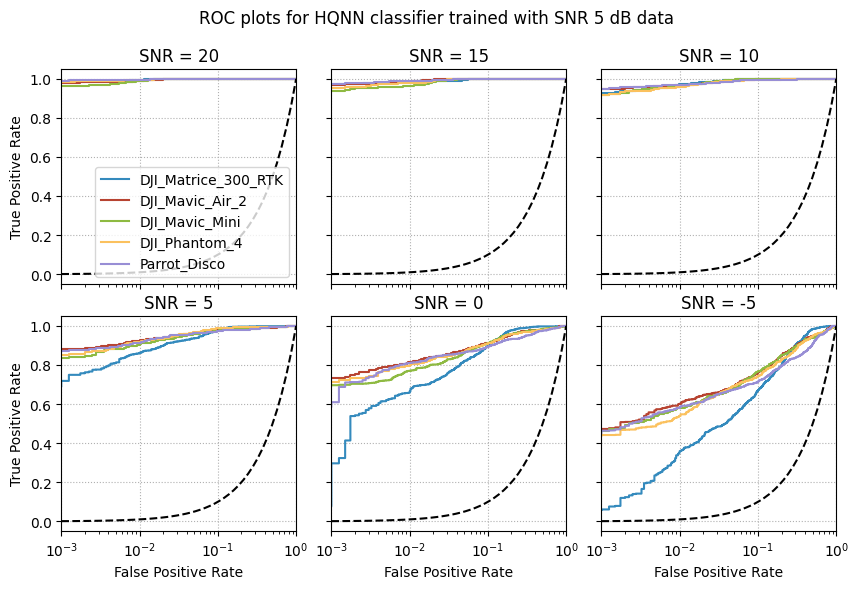

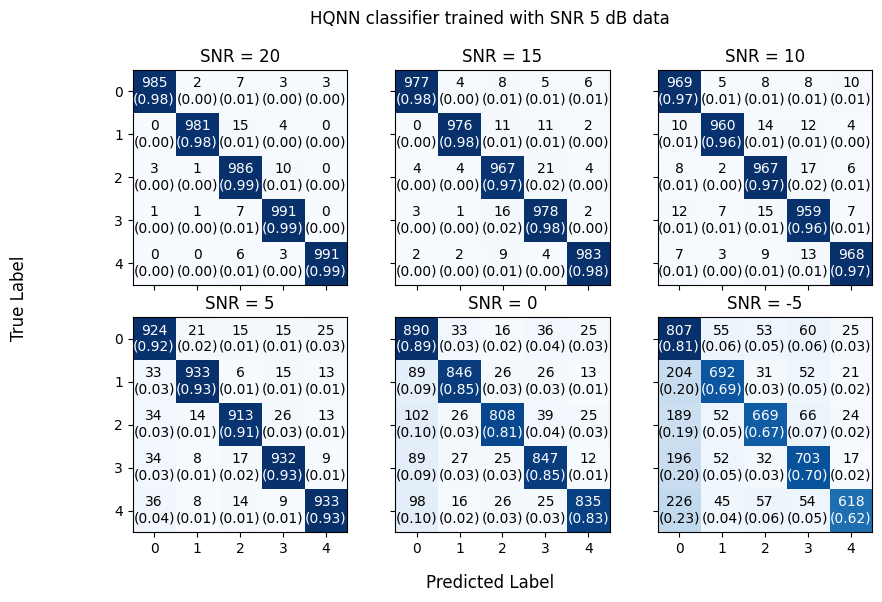

In [ ]:
from itertools import cycle

def evaluate_model(model, loader):
    target = None
    probabilities = None
    predicted = None
    testloss = 0

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if target is None:
            target = labels
        else:
            target = torch.cat((target, labels))

        outputs = model(inputs.float())
        loss = loss_fn(outputs, labels)
        testloss += loss.item()

        partial_probabilities = nn.Softmax(dim=1)(outputs.data)
        if probabilities is None:
            probabilities = partial_probabilities
        else:
            probabilities = torch.cat((probabilities, partial_probabilities))

        _, partial_predicted = torch.max(outputs.data, 1)

        if predicted is None:
            predicted = partial_predicted
        else:
            predicted = torch.cat((predicted, partial_predicted))
    return target, predicted, probabilities


def calc_model_f1_scores(pred, real):
    f1_scores = {}
    for idx, snr in enumerate(test_snrs):
        f1_scores[snr] = float(multiclass_f1_score(pred[idx], real[idx], num_classes=5, average='micro').numpy())
    return f1_scores


def print_f1_scores(mdl_snr, pred, real):
    f1_scores = calc_model_f1_scores(pred, real)

    print("\n\n")
    print(f"F1 Scores for Model Trained with SNR={mdl_snr}\n")
    print("Signal SNR      F1 Score")
    print("------------------------")
    for snr, f1 in f1_scores.items():
        print(f"{snr:^8}:     {f1:.3f}")
    print("\n\n")


def plot_confusion_matrices(mdl_snr, snrs, pred, real):
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(nrows=2, ncols=3, hspace=0.15, wspace=0.05)
    axs = gs.subplots(sharex='col', sharey='row')
    for idx, snr in enumerate(confusion_snrs):
        col = idx % 3
        row = idx // 3
        confm = confusion_matrix(target[idx], predicted[idx])
        plot_confusion_matrix(conf_mat=confm,
                              figure=fig,
                              axis=axs[row, col],
                              show_normed=True,
                              colorbar=False)
        axs[row, col].set_title(f"SNR = {snr}")
        axs[row, col].label_outer()
    axs[1,2].set_xlabel("")
    axs[1,2].set_ylabel("")
    fig.supxlabel("Predicted Label")
    fig.supylabel("True Label")
    fig.suptitle(f"HQNN classifier trained with SNR {mdl_snr} dB data")
    plt.tight_layout()
    plt.savefig(f"{plot_path}/hybrid_classifier_confusion_snr_{mdl_snr}.pdf")


def plot_roc_plots(mdl_snr, targets, probs, remove_zeros=False, semilog_axes=True):
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(nrows=2, ncols=3, hspace=0.15, wspace=0.15)
    axs = gs.subplots(sharex='col', sharey='row')
    colors = cycle(['#348ABD', '#b74331', '#8EBA42', '#FBC15E', '#988ED5'])
    for idx, (snr, real, probability) in enumerate(zip(test_snrs, targets.values(), probs.values())):
        col = idx % 3
        row = idx // 3
        ax = axs[row, col]
        lb = LabelBinarizer().fit(real)
        one_hot_target = lb.transform(real)
        for class_id, color in zip(range(5), colors):
            fpr, tpr, _ = roc_curve(one_hot_target[:,class_id], probability[:,class_id])
            if remove_zeros is True:
                zero_indices = np.where(np.isclose(fpr, 0))
                fpr = np.delete(fpr, zero_indices)
                tpr = np.delete(tpr, zero_indices)
            else:
                fpr[np.isclose(fpr,0)] = 1e-10
            display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(
                name=f"{drone_type_map[class_id]}",
                ax=ax,
                color=color)
        if semilog_axes is True:
            display.ax_.set_xscale("log")
            display.ax_.set_xlim(roc_curve_minimum, 1.0)
        display.ax_.set_xlabel("False Positive Rate")
        display.ax_.set_ylabel("True Positive Rate")
        display.ax_.set_title(f"SNR = {snr}")
        display.ax_.grid(linestyle=':')
        line = display.ax_.plot(np.geomspace(roc_curve_minimum,1.0), np.geomspace(roc_curve_minimum,1.0),
                                color='k', linestyle="dashed", label="Chance")
        display.ax_.label_outer()
        if idx != 0:
            display.ax_.get_legend().remove()
    fig.suptitle(f"ROC plots for HQNN classifier trained with SNR {mdl_snr} dB data")
    plt.tight_layout()
    plt.savefig(f"{plot_path}/hybrid_classifier_roc_plots_snr_{mdl_snr}.pdf")

# ---------- Run model evaluations and save results

model_snr = 5
test_snrs = [20, 15, 10, 5, 0, -5]

target = {}
predicted = {}
probabilities = {}

for idx, snr in enumerate(test_snrs):
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 8
    conf['epochs'] = 10
    conf['learning_rate'] = 0.0005
    conf['plot_confusion'] = True
    conf['model_path'] = f"{model_path}/hybrid-parallel-model-{model_snr}.pt"

    testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
    testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
    testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

    net = HybridRadarClassifier(conf).to(device)
    net.load_state_dict(torch.load(conf['model_path']))
    net.eval()

    correct = 0
    total = 0
    testloss = 0
    loss_fn = nn.CrossEntropyLoss().to(device)
    confm = np.zeros((2, 2), dtype=int)

    print(f"Model evaluation for SNR={snr}")
    target[idx], predicted[idx], probabilities[idx] = evaluate_model(net, testLoader)

# ---------- F1 scores


print_f1_scores(model_snr, predicted, target)


# ---------- ROC plots


plot_roc_plots(model_snr, target, probabilities)


# ---------- Confusion matrices

# Note: If the number of entries in this list is changed then the plot
# code in plot_confusion_matrices will need to be updated.
confusion_snrs = [20, 15, 10, 5, 0, -5]

plot_confusion_matrices(model_snr, confusion_snrs, predicted, target)


### Generate Plot of SNR Against F1 Score

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


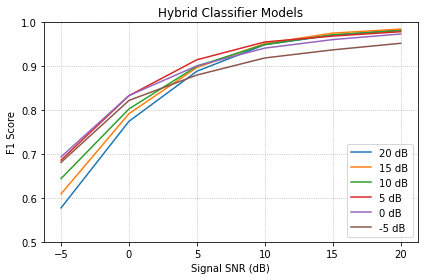

In [ ]:
model_snrs = [20, 15, 10, 5, 0, -5]
test_snrs = [20, 15, 10, 5, 0, -5]


f1_scores = {}
for model_snr in model_snrs:
    target = {}
    predicted = {}
    probabilities = {}

    for idx, snr in enumerate(test_snrs):
        conf = {}
        conf['f_s'] = 10_000
        conf['SNR'] = snr
        conf['batch_size'] = 8
        conf['epochs'] = 10
        conf['learning_rate'] = 0.0005
        conf['plot_confusion'] = True
        conf['model_path'] = f"{model_path}/hybrid-parallel-model-{model_snr}.pt"

        testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
        testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
        testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

        net = HybridRadarClassifier(conf).to(device)
        net.load_state_dict(torch.load(conf['model_path']))
        net.eval()

        correct = 0
        total = 0
        testloss = 0
        loss_fn = nn.CrossEntropyLoss().to(device)
        confm = np.zeros((2, 2), dtype=int)

        target[idx], predicted[idx], probabilities[idx] = evaluate_model(net, testLoader)

    f1_scores[model_snr] = calc_model_f1_scores(predicted, target)


fig = plt.figure(figsize=(6.0, 4.0), dpi=72)
ax = fig.add_subplot(111)
ax.grid(linestyle=':')
ax.grid(which='both', axis='x', linestyle=':')
_ = ax.set_ylim([0.5, 1.0])
ax.set_title("Hybrid Classifier Models")
ax.set_xlabel("Signal SNR (dB)")
ax.set_ylabel("F1 Score")
for model_snr, snr_dict in f1_scores.items():
    _ = ax.plot(snr_dict.keys(), snr_dict.values(), label=f"{model_snr} dB")
_ = ax.legend()
fig.tight_layout()
plt.savefig(f"{plot_path}/hybrid_classifier_f1_scores.eps")


### Generate an Ensemble of Model Evaluations

In [ ]:
import json

data_dir = "test_sets/two_sided"
model_snr = 5
test_snrs = [20, 15, 10, 5, 0, -5]
test_datasets = ["testset_0", "testset_1", "testset_2", "testset_3", "testset_4"]

print(f"Calculating F1 score ensemble for model SNR = {model_snr}")

f1_scores = {}
for test_dataset in test_datasets:
    target = {}
    predicted = {}
    probabilities = {}

    print(f"  Calculating F1 scores for testset = '{test_dataset}'")

    for idx, snr in enumerate(test_snrs):
        conf = {}
        conf['f_s'] = 10_000
        conf['SNR'] = snr
        conf['batch_size'] = 8
        conf['epochs'] = 10
        conf['learning_rate'] = 0.0005
        conf['plot_confusion'] = True
        conf['model_path'] = f"{model_path}/hybrid-parallel-model-{model_snr}.pt"

        #print(f"    Calculating F1 scores for signal SNR = {snr}")
        testset_root = f"{radar_path}/{data_dir}/{test_dataset}/{conf['f_s']}fs/{conf['SNR']}SNR"
        testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
        testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

        net = HybridRadarClassifier(conf).to(device)
        net.load_state_dict(torch.load(conf['model_path']))
        net.eval()

        correct = 0
        total = 0
        testloss = 0
        loss_fn = nn.CrossEntropyLoss().to(device)
        confm = np.zeros((2, 2), dtype=int)

        target[idx], predicted[idx], probabilities[idx] = evaluate_model(net, testLoader)

    f1_scores[test_dataset] = calc_model_f1_scores(predicted, target)

f1_scores_file = f"{plot_path}/hybrid_model_snr{model_snr}_ensemble_f1_scores.json"
with open(f1_scores_file, 'w') as fd:
    json.dump(f1_scores, fd)

snr_list = [[snr for snr in d.keys()] for d in f1_scores.values()][0]
f1_arrays = [np.array(l) for l in [[d[snr] for d in f1_scores.values()] for snr in snr_list]]
f1_means = [np.mean(f1_array) for f1_array in f1_arrays]
f1_stddevs = [np.std(f1_array) for f1_array in f1_arrays]

print("\n\n")
print(f"  Hybrid Classifier for {model_snr}dB")
print("  SNR   Mean F1  F1 Std. dev.")
print("-----------------------------")
for i, snr in enumerate(snr_list):
    print(f"{snr:>5}: {f1_means[i]:7.3f}  {f1_stddevs[i]:9.6f}")


Calculating F1 score ensemble for model SNR = 5
  Calculating F1 scores for testset = 'testset_0'
  Calculating F1 scores for testset = 'testset_1'
  Calculating F1 scores for testset = 'testset_2'
  Calculating F1 scores for testset = 'testset_3'
  Calculating F1 scores for testset = 'testset_4'



  Hybrid Classifier for 5dB
  SNR   Mean F1  F1 Std. dev.
-----------------------------
   20:   0.979   0.003231
   15:   0.972   0.002915
   10:   0.954   0.003957
    5:   0.917   0.003056
    0:   0.840   0.007845
   -5:   0.685   0.007200
